## Library

In [46]:
# Core PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.amp.autocast_mode import autocast
from torch.amp.grad_scaler import GradScaler

# Torchvision imports
from torchvision import datasets, models, transforms
from torchvision.models import resnet18, ResNet18_Weights

# Utility imports
from torchsummary import summary
from tqdm import tqdm
from copy import deepcopy

# Data handling & system
import os
import zipfile
import pathlib
import pandas as pd
import numpy as np
from PIL import Image

# Visualization
import matplotlib.pyplot as plt

# Misc
import random
import time

# Boost performance for CUDA
torch.backends.cudnn.benchmark = True


In [7]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Path Dir

In [8]:
zip_path = os.path.join("C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data", "gender.zip")
extract_path = "C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender"

# Only extract if not already extracted
if not os.path.exists(extract_path) or not os.listdir(extract_path):
    print("Extracting ZIP file with style...")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        files = zip_ref.infolist()

        for file in tqdm(files, desc="Extracting", unit="file", ncols=80, bar_format="{l_bar}{bar} | {n_fmt}/{total_fmt}"):
            zip_ref.extract(file, extract_path)

    print("✨ Extraction complete.")
else:
    print("✅ Already extracted. Skipping extraction.")


✅ Already extracted. Skipping extraction.


In [ ]:
train_dir = "C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender/Train"
test_dir = "C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender/Test"

# Get the class names from the target directory
classes = sorted([entry.name for entry in list(os.scandir(train_dir))])
print(f"Class names: {classes}")

Class names: ['female', 'male']


In [14]:
#######################################################
#      Create dictionary for class indexes
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
class_to_idx

{'female': 0, 'male': 1}

In [11]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(train_dir)

There are 2 directories and 0 images in 'C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender/Train'.
There are 0 directories and 23243 images in 'C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender/Train\female'.
There are 0 directories and 23766 images in 'C:/IIUM/AI Note IIUM/Deep_Learning/Week After (W9+)/data/Gender/Train\male'.


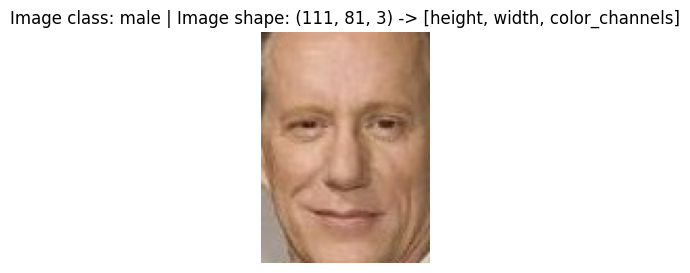

In [13]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(pathlib.Path(train_dir).glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(5, 3))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

# Custom Dataset

In [15]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None, extensions={".jpg", ".jpeg", ".png"}):
        self.image_paths = [
            path for ext in extensions 
            for path in pathlib.Path(image_dir).rglob(f"*{ext}")
        ]
        self.transform = transform

        # Get all class names from folder names
        class_names = sorted({path.parent.name for path in self.image_paths})
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

        print(f"📸 Found {len(self.image_paths)} images across {len(self.class_to_idx)} classes.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # ensure consistent 3-channel RGB

        # Get label from folder name
        label_name = image_path.parent.name
        label = self.class_to_idx[label_name]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [17]:
# Define transformations
data_transform = transforms.Compose(
    [transforms.Resize((224,224)), # Note the difference here compared to before
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])

In [ ]:
train_data_custom = CustomDataset(image_dir=train_dir, transform=data_transform) # type: ignore
test_data_custom = CustomDataset(image_dir=test_dir, transform=data_transform) # type: ignore

📸 Found 47009 images across 2 classes.
📸 Found 11649 images across 2 classes.


In [16]:
len(train_dir), len(test_dir)

(69, 68)

In [20]:
# Create ImageFolder datasets for comparison if not already created
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data) == len(train_data)) & (len(test_data) == len(test_data)))

True


## Data Loader

In [ ]:
#######################################################
#                  Create Dataloader                  #
#######################################################

# Turn train and test custom Dataset's into DataLoader's

num_workers = (os.cpu_count() or 2) // 2

train_loader = DataLoader(
    dataset=train_data,
    batch_size=128,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_data,
    batch_size=128,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=True
)

In [25]:
# Load model with updated syntax
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Adjust the final layer for 3 output classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

# Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Move model to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
model.to(device)
summary(model, (3, 224, 224)) # For ResNet18, input size is (3, 224, 224)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Training Loop


In [ ]:

def train_and_validate(model, loss_criterion, optimizer, train_dataloader, test_dataloader, epochs=25, device='cuda'):
    scaler = GradScaler()  # AMP scaler magic
    start_time = time.time()
    model = model.to(device)
    best_acc = 0.0
    best_model_state = deepcopy(model.state_dict())
    history = []

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"\nEpoch {epoch+1}/{epochs}")

        # TRAIN with AMP scaler
        train_loss, train_acc = run_epoch(model, train_dataloader, loss_criterion, optimizer, device, train=True, scaler=scaler)

        # VALIDATION without optimizer and no grad scaling needed
        val_loss, val_acc = run_epoch(model, test_dataloader, loss_criterion, device=device, train=False, scaler=None)

        history.append([train_loss, val_loss, train_acc, val_acc])

        print(f"Epoch {epoch+1:03d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}% | "
              f"Time: {time.time() - epoch_start:.2f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_state = deepcopy(model.state_dict())
            torch.save(model, 'best_model_Gender.pt')

    model.load_state_dict(best_model_state)
    total_time = time.time() - start_time
    print(f"\nTraining complete in {total_time:.2f}s. Best Validation Accuracy: {best_acc*100:.2f}%")
    return model, history


def run_epoch(model, dataloader, loss_criterion, optimizer=None, device='cuda', train=True, scaler=None):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        if train and optimizer is not None:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train):
            # AMP autocast context — float16 precision for forward pass
            with autocast(device_type='cuda', enabled=(scaler is not None)): 
                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

            if train and optimizer is not None:
                if scaler is not None:
                    # scale loss, backward, optimizer step, update scaler
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct += (preds == labels).sum().item()
        total += inputs.size(0)

    avg_loss = total_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


In [44]:
# Train the model for 10 epochs

num_epochs = 10
trained_model, history = train_and_validate(model, loss_fn, optimizer, train_loader, test_loader, num_epochs)


Epoch 1/10
Epoch 001 | Train Loss: 0.0525, Acc: 98.14% | Val Loss: 0.0800, Acc: 97.06% | Time: 103.94s

Epoch 2/10
Epoch 002 | Train Loss: 0.0400, Acc: 98.66% | Val Loss: 0.0827, Acc: 97.13% | Time: 108.09s

Epoch 3/10
Epoch 003 | Train Loss: 0.0279, Acc: 99.15% | Val Loss: 0.0840, Acc: 97.15% | Time: 110.93s

Epoch 4/10
Epoch 004 | Train Loss: 0.0178, Acc: 99.51% | Val Loss: 0.0926, Acc: 97.01% | Time: 111.79s

Epoch 5/10
Epoch 005 | Train Loss: 0.0113, Acc: 99.77% | Val Loss: 0.0975, Acc: 97.14% | Time: 111.74s

Epoch 6/10
Epoch 006 | Train Loss: 0.0080, Acc: 99.89% | Val Loss: 0.0993, Acc: 97.13% | Time: 111.67s

Epoch 7/10
Epoch 007 | Train Loss: 0.0057, Acc: 99.95% | Val Loss: 0.1023, Acc: 97.17% | Time: 111.83s

Epoch 8/10
Epoch 008 | Train Loss: 0.0043, Acc: 99.96% | Val Loss: 0.1070, Acc: 97.08% | Time: 111.71s

Epoch 9/10
Epoch 009 | Train Loss: 0.0033, Acc: 99.99% | Val Loss: 0.1117, Acc: 97.12% | Time: 111.88s

Epoch 10/10
Epoch 010 | Train Loss: 0.0030, Acc: 99.99% | Val L

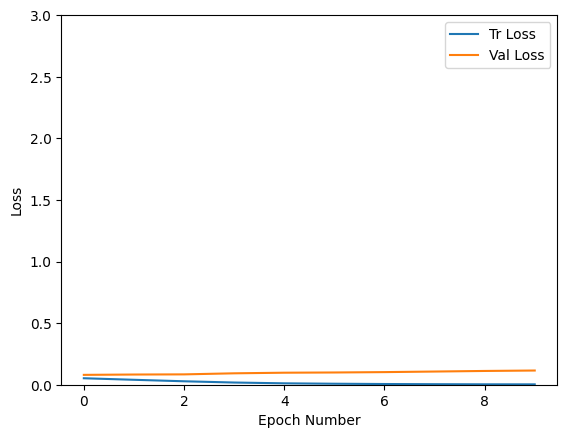

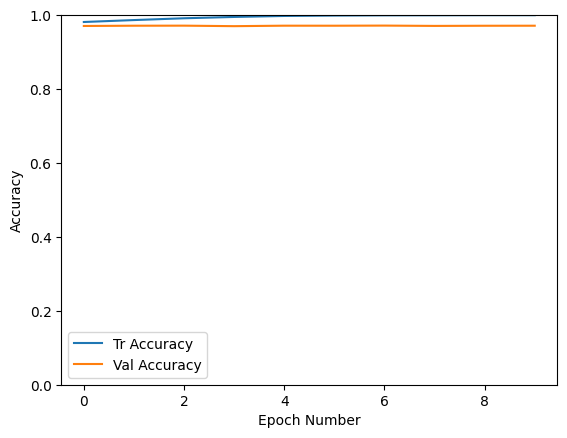

In [45]:
# Loss curve

history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
# plt.savefig('cifar10_loss_curve.png')
plt.show()

# Accuracy curve

plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
# plt.savefig('cifar10_accuracy_curve.png')
plt.show()